In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Flatten, Dropout
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [33]:
columns = ['activity', 'x_axis', 'y_axis', 'z_axis']
df = pd.read_csv('/content/drive/MyDrive/MCA Main Project/HAPT RawExtracted/TrainingData/Train.txt', header=None, sep = ' ',names = columns)
df = df.dropna()
df.head()

# Applying the condition
df['activity'].mask(df['activity'] == 1, 'Walking', inplace=True)
df['activity'].mask(df['activity'] == 2, 'Upstairs', inplace=True)
df['activity'].mask(df['activity'] == 3, 'Downstairs', inplace=True)
df['activity'].mask(df['activity'] == 4, 'Sitting', inplace=True)
df['activity'].mask(df['activity'] == 5, 'Standing', inplace=True)
df['activity'].mask(df['activity'] == 6, 'Laying', inplace=True)

df

,activity,x_axis,y_axis,z_axis
0,Walking,1.420833,-0.340278,-0.125000
1,Walking,1.002778,-0.204167,-0.108333
2,Walking,0.683333,-0.061111,-0.108333
3,Walking,0.733333,-0.083333,-0.120833
4,Walking,0.956944,-0.263889,-0.137500
...,...,...,...,...
134871,Laying,0.147222,0.851389,0.506944
134872,Laying,0.154167,0.850000,0.502778
134873,Laying,0.161111,0.851389,0.493056
134874,Laying,0.159722,0.851389,0.498611


In [27]:
df.head(11)

,activity,x-axis,y-axis,z-axis
0,Walking,1.420833,-0.340278,-0.125000
1,Walking,1.002778,-0.204167,-0.108333
2,Walking,0.683333,-0.061111,-0.108333
3,Walking,0.733333,-0.083333,-0.120833
4,Walking,0.956944,-0.263889,-0.137500
5,Walking,1.050000,-0.402778,-0.144444
6,Walking,1.013889,-0.415278,-0.104167
7,Walking,0.950000,-0.393056,-0.105556
8,Walking,0.950000,-0.359722,-0.102778
9,Walking,0.952778,-0.315278,-0.086111


In [34]:
# removing null values

df = df.dropna()
df.shape

(134876, 4)

In [29]:
# # processing z-axis values - removing ; from the value

# df['z_axis'] = df['z_axis'].str.replace(';','')
# df['z_axis'] = df['z_axis'].apply(lambda x:float(x))

In [ ]:
# arrange data in ascending order of user and timestamp

df = df.sort_values(by=['user_id','timestamp'],ignore_index=True)

In [ ]:
df.head()

In [ ]:
sns.set_style("whitegrid")
sns.countplot(x = 'activity', data = df)
plt.title('Human Activity Recognition')
plt.show()

In [ ]:
ax = df.groupby(['user_id'])['user_id'].count().plot.bar(title="Human Activity Recognition", ylabel='Counts: per user_id activity occurs',figsize=(14,8))

In [35]:
random_seed = 42
n_time_steps = 50
n_features = 3
step = 10
n_classes = 6
n_epochs = 50
batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015

In [36]:
segments = []
labels = []

for i in range(0, df.shape[0] - n_time_steps, step):
    
    xs = df['x_axis'].values[i: i + 50]
    ys = df['y_axis'].values[i: i + 50]
    zs = df['z_axis'].values[i: i + 50]
    
    label = stats.mode(df['activity'][i: i + 50])[0][0]
    
    segments.append([xs,ys,zs])
    
    labels.append(label)

# reshape the segments which is(list of arrays) to a list

reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-1, n_time_steps, n_features)

labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)

In [37]:
reshaped_segments.shape

(13483, 50, 3)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=random_seed)

In [39]:
# Building Model Architecture

model = Sequential()

# RNN layer

#model.add(LSTM(units=128, input_shape=(X_train.shape[1],X_train.shape[2] )))

model.add(GRU(units=128, input_shape=(X_train.shape[1],X_train.shape[2] )))

# Dropout layer

model.add(Dropout(0.5))

# Dense layer with ReLu

model.add(Dense(units=64, activation='relu'))

# Softmax layer

model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               51072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 59,718
Trainable params: 59,718
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model.fit(X_train, y_train, epochs=n_epochs, validation_split=0.2, batch_size=batch_size, verbose=1)

Epoch 1/50
9/9 [==============================] - 6s 480ms/step - loss: 1.7372 - accuracy: 0.2503 - val_loss: 1.6414 - val_accuracy: 0.2822
Epoch 2/50
9/9 [==============================] - 4s 449ms/step - loss: 1.5863 - accuracy: 0.2850 - val_loss: 1.4953 - val_accuracy: 0.3369
Epoch 3/50
9/9 [==============================] - 4s 429ms/step - loss: 1.4524 - accuracy: 0.3329 - val_loss: 1.3844 - val_accuracy: 0.3545
Epoch 4/50
9/9 [==============================] - 4s 436ms/step - loss: 1.3850 - accuracy: 0.3566 - val_loss: 1.3412 - val_accuracy: 0.3971
Epoch 5/50
9/9 [==============================] - 4s 442ms/step - loss: 1.3560 - accuracy: 0.3770 - val_loss: 1.3082 - val_accuracy: 0.4222
Epoch 6/50
9/9 [==============================] - 4s 451ms/step - loss: 1.3263 - accuracy: 0.4067 - val_loss: 1.2887 - val_accuracy: 0.4425
Epoch 7/50
9/9 [==============================] - 4s 436ms/step - loss: 1.3035 - accuracy: 0.4130 - val_loss: 1.2658 - val_accuracy: 0.4041
Epoch 8/50
9/9 [====

In [42]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size,verbose=1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

3/3 [==============================] - 0s 133ms/step - loss: 0.8093 - accuracy: 0.6251
Test Accuracy : 0.625139057636261
Test Loss : 0.8092846870422363


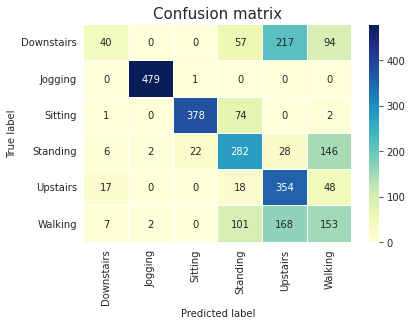

In [43]:
# Confusion matrix
import sklearn.metrics as metrics

predictions = model.predict(X_test)
class_labels = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True,linewidths=0.1,fmt='d', cmap='YlGnBu')
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

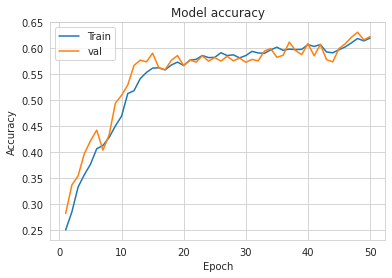

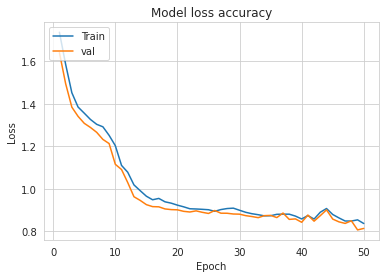

In [44]:
def plot_learningCurve(history,epochs):

  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','val'],loc='upper left')
  plt.show()

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss accuracy')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train','val'],loc='upper left')
  plt.show()

plot_learningCurve(history,50)